In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### text-to-img

In [3]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# GLIDE 3B has been used // StableDiffusion 2 trained on LAION-5B
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    # "stabilityai/stable-diffusion-2-1", # 8GB VRAM are not sufficient lol
    torch_dtype=torch.float16,
).to(device)

# Low GPU ram mode (but slower) 
pipe.enable_attention_slicing()

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "a corgi"
prompt_details = " solid white background, full body centered front camera view, blender render, high resolution, standard light"
generated_image = pipe(prompt + prompt_details).images[0]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

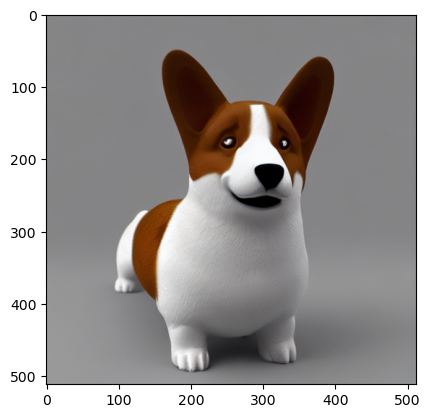

In [4]:
import matplotlib.pyplot as plt
plt.imshow(generated_image)

In [5]:
from torchvision import transforms
PILtoTensor = transforms.ToTensor()
#generated_image = PILtoTensor(generated_image)

del pipe
torch.cuda.empty_cache()

### img-to-pointcloud

In [6]:
base_name = 'base40M' # use base300M or base1B for better results
n_points = 1024
final_n_points = 6192
MODEL_CONFIGS[base_name]["n_ctx"] = n_points
MODEL_CONFIGS["upsample"]["n_ctx"] = final_n_points - n_points

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [7]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[n_points, final_n_points - n_points], # point clouds and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [8]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[generated_image]))):
    samples = x

0it [00:00, ?it/s]

In [9]:
samples.shape

torch.Size([1, 6, 6192])

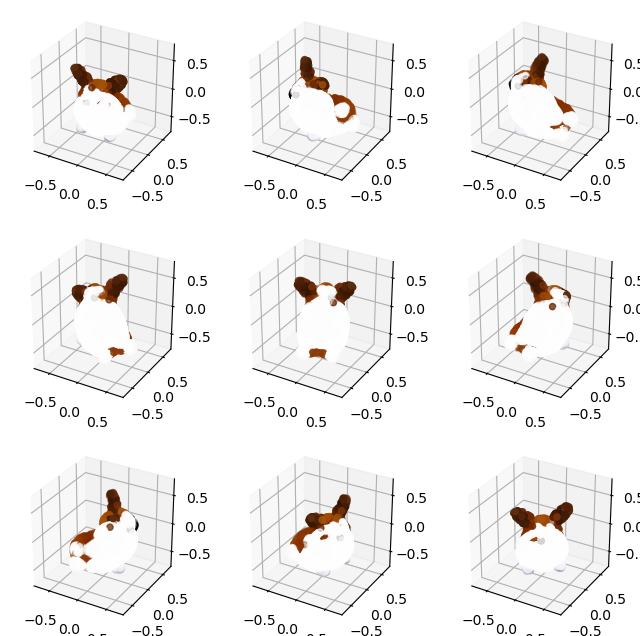

In [10]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))